In [1]:
from datetime import time
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from dataclasses import dataclass
from pathlib import Path
import joblib

from config import (COMPONENTS_2D, MARKET_OPEN_SECONDS, PLOT, t_start, SAVE_DIR)
from diagnostics import diagnostics, plot_hjb_policy_heatmap
from event_cleaning import prepare_hawkes_events
from OrderBook import OrderBook
from HawkesCalibrator import LOBHawkes, HawkesCalibrator
from control_frame import ControlBacktester, simulate_mid_paths
from microstructure_calibration import calibrate_fill_probability, calibrate_price_impact
from plot_hawkes import HawkesPlotter
from utils import (t_rel, apply_time_of_day_axis, _sec_to_clock_str, _choose_tick_step)
from hjb_theta_solver  import (HJBThetaIMEXSolver, HJBSolverParams,
                             HJBQuotePolicyFromSolution, hjb_signature, 
                             cache_load_or_compute, estimate_sigma_arithmetic,
                             estimate_tick_size_from_series, estimate_quote_tick_from_bid_ask,
                             intensity_on_real_episode_2d, slice_event_counts,
                             slice_mid_episode, HawkesBacktestModel, HJBPolicyAdapter)

In [2]:
# msg_file = "LOBSTER_sample\GOOG_2012-06-21_34200000_57600000_message_10.csv"
# lob_file = "LOBSTER_sample\GOOG_2012-06-21_34200000_57600000_orderbook_10.csv"

In [3]:
# msg_file = "LOBSTER_sample\AMZN_2012-06-21_34200000_57600000_message_10.csv"
# lob_file = "LOBSTER_sample\AMZN_2012-06-21_34200000_57600000_orderbook_10.csv"

In [4]:
msg_file = "LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_message_10.csv"
lob_file = "LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_orderbook_10.csv"

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\andre\AppData\Local\Temp\ipykernel_26868\50585678.py:1: SyntaxWarning: invalid escape sequence '\A'
  msg_file = "LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_message_10.csv"
C:\Users\andre\AppData\Local\Temp\ipykernel_26868\50585678.py:2: SyntaxWarning: invalid escape sequence '\A'
  lob_file = "LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_orderbook_10.csv"


In [5]:
symbol = Path(lob_file).name.split("_")[0]
print("ticker:", symbol)


ticker: AAPL


Loading LOBSTER data: LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_message_10.csv and LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_orderbook_10.csv
Loading LOBSTER data from:
 MSG: LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_message_10.csv
 LOB: LOBSTER_sample\AAPL_2012-06-21_34200000_57600000_orderbook_10.csv...
Data loaded successfully.
Time Range: 34200.0s - 57599.9s
Extracted Events (LOBSTER Logic):
 L_b: 82520, L_a: 108495
 E_b (MO Sell): 18261, E_a (MO Buy): 16729
 C_b: 74799, C_a: 99587


Deep Imbalance (rho_5L) calculated. Mean: 0.0996


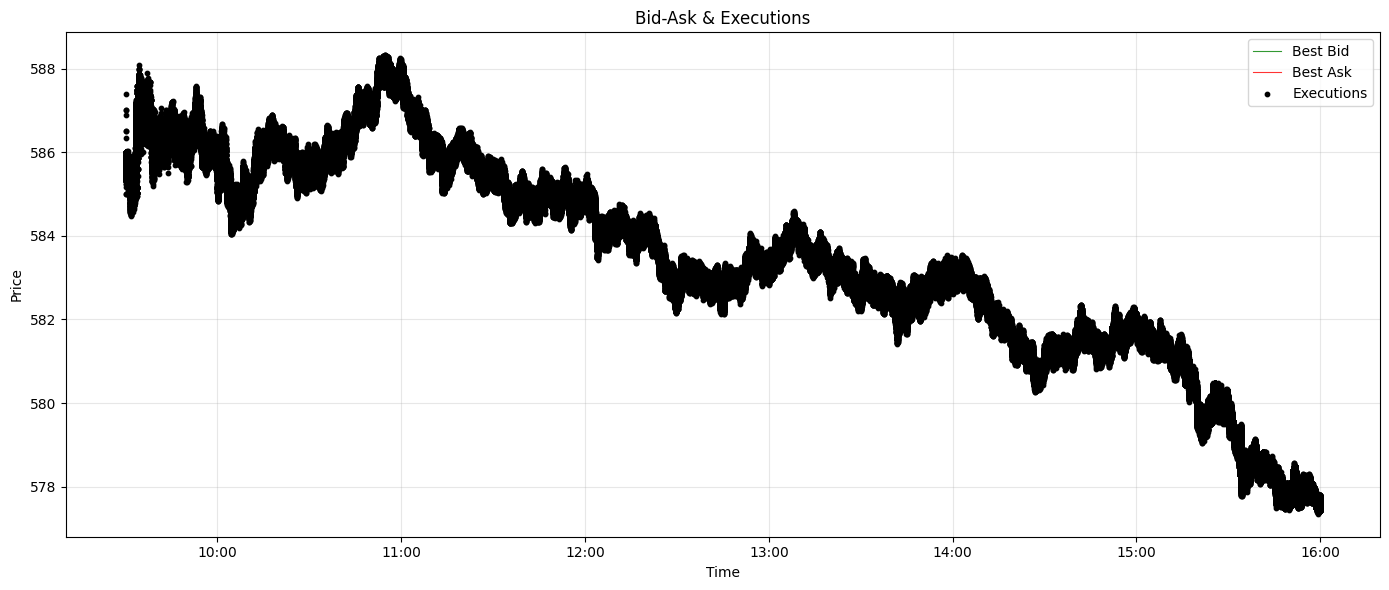

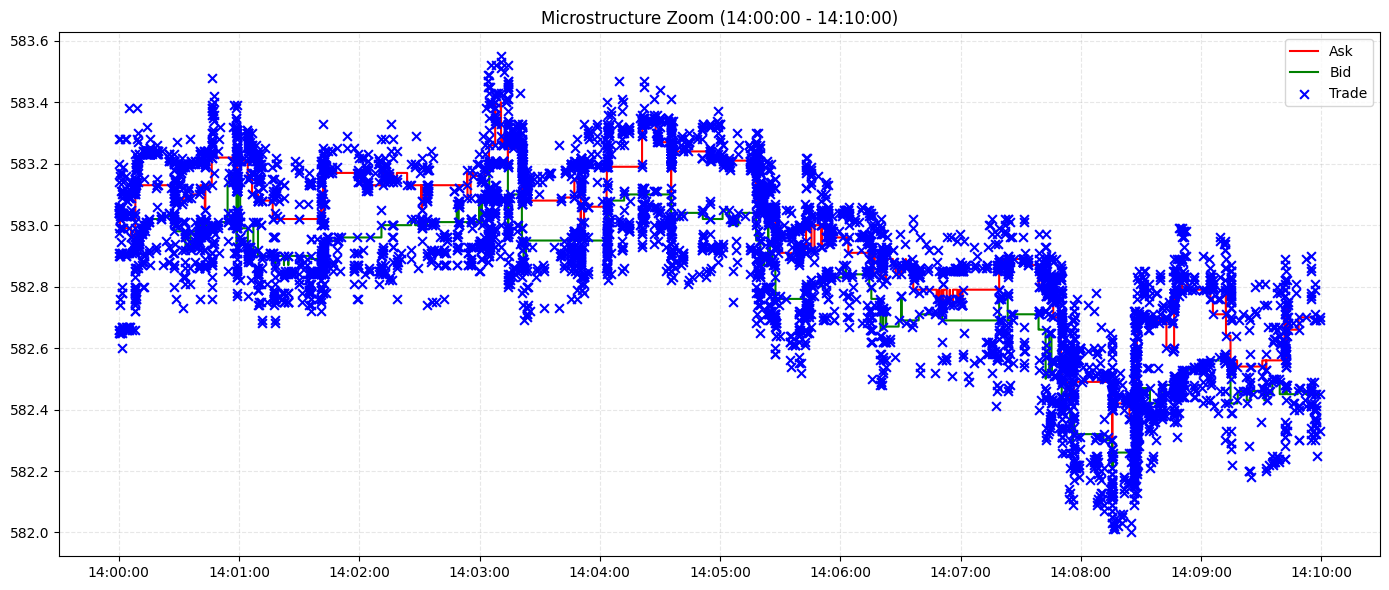

c:\Users\andre\Desktop\Tesi\code\plot_hawkes.py:188: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlc = df_plot[col_to_use].resample(resample_rule).ohlc()


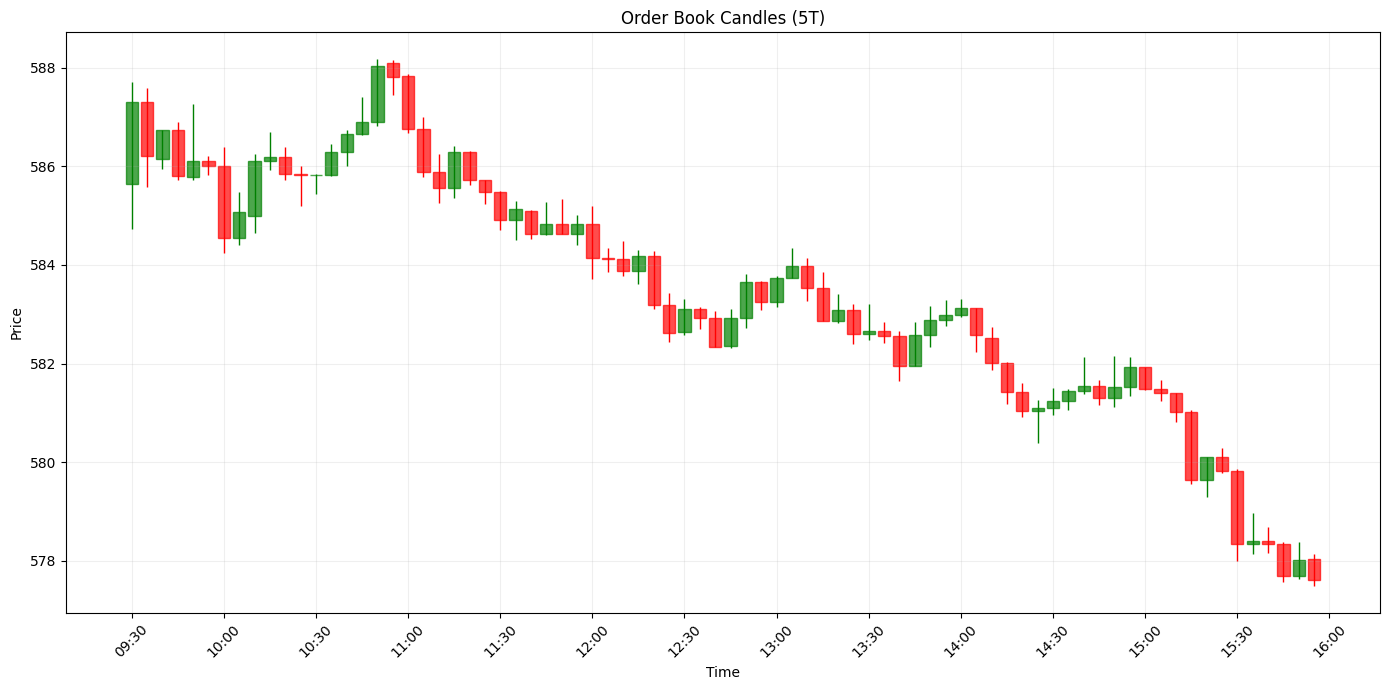

In [6]:
print(f"Loading LOBSTER data: {msg_file} and {lob_file}")
ob = OrderBook(message_file=msg_file, orderbook_file=lob_file, ticker=symbol)
data = ob.LimitOrderBook
events, T_day = ob.to_hawkes_events_10d_robust(debug=True)

print(f"\n\nDeep Imbalance (rho_5L) calculated. Mean: {data['rho_5L'].mean():.4f}")

plotter = HawkesPlotter()

if PLOT:
    plotter.plot_price_action(data)

    plotter.plot_price_zoom(data, time(14, 0, 0), time(14, 10, 0))

    plotter.plot_candles(data, resample_rule='5T')

In [7]:
df = ob.LimitOrderBook
df = df[df["time"] >= MARKET_OPEN_SECONDS].copy().reset_index(drop=True)
df["time"] -= MARKET_OPEN_SECONDS

ob.LimitOrderBook = df                                
data = ob.LimitOrderBook                              

events, T = ob.to_hawkes_events_10d_robust(debug=False)
events, marks, meta = prepare_hawkes_events(
    events_raw=events,
    components=COMPONENTS_2D,
    collapse_tol=0.0,
    global_tie_break=True,
    eps="auto"
)

print("[EVENT CLEAN] raw counts:", meta["n_raw"])
print("[EVENT CLEAN] collapsed counts:", meta["n_collapsed"])
print("[EVENT CLEAN] eps used:", meta["eps_used"])
print("[EVENT CLEAN] dt0_after:", meta["dt0_after"])

print(f"\n\nBuilt 10D events, T_day = {T:.1f} seconds")
lob2 = LOBHawkes(events, T)


[EVENT CLEAN] raw counts: {'E_b': 18261, 'E_a': 16729}
[EVENT CLEAN] collapsed counts: {'E_b': 13082, 'E_a': 11779}
[EVENT CLEAN] eps used: 7.700000423938036e-10
[EVENT CLEAN] dt0_after: {'E_b': {'n': 13082, 'share_dt0': 0.0}, 'E_a': {'n': 11779, 'share_dt0': 0.0}}


Built 10D events, T_day = 23399.9 seconds


In [8]:
FILENAME = f"hawkes_2d_fit_results_{symbol}.pkl"
FILEPATH = os.path.join(SAVE_DIR, FILENAME)

# Ensure directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

windows = [
    (t_rel(10, 0), t_rel(12, 0)),
    (t_rel(12, 0), t_rel(14, 0)),
    (t_rel(14, 0), t_rel(16, 0))
]

print("\nFitting 2D Hawkes on windows:")
for k, (t0, t1) in enumerate(windows):
    print(f"  window {k}: [{t0:.0f}, {t1:.0f})  (len={(t1-t0):.0f}s)")

# ------------------------------------------------------------------
# 4) Calibra Hawkes 2D per finestre (WITH CACHING)
#    -> ottieni dict: {win_idx: WindowResult2D}
# ------------------------------------------------------------------
if os.path.exists(FILEPATH):
    print(f"\n[CACHE] Found saved fit at '{FILEPATH}'. Loading...")
    with open(FILEPATH, "rb") as f:
        win_results = pickle.load(f)
    print("[CACHE] Loaded successfully.")
else:
    print(f"\n[CACHE] File '{FILEPATH}' not found. Running calibration...")
    
    win_results = lob2.fit_windows(
        windows,
        deseasonalize=False,
        rho_cap_fit=0.999,     # fit is “free” but prevented from going supercritical
    )

    
    print(f"[CACHE] Saving results to '{FILEPATH}'...")
    with open(FILEPATH, "wb") as f:
        pickle.dump(win_results, f)
    print("[CACHE] Saved.")

# --- Verification of loaded/fitted results ---
print("\n=== Window fits summary ===")
for k in sorted(win_results.keys()):
    wr = win_results[k]
    print(f"Window {k}: [{wr.t0:.0f}, {wr.t1:.0f}), rho={wr.fit.rho:.3f}")
    for name, mZ in zip(COMPONENTS_2D, wr.meanZ):
        print(f"   {name}: mean(Z)={mZ:.3f}")
    print()




Fitting 2D Hawkes on windows:
  window 0: [1800, 9000)  (len=7200s)
  window 1: [9000, 16200)  (len=7200s)
  window 2: [16200, 23400)  (len=7200s)

[CACHE] File 'cache\hawkes_2d_fit_results_AAPL.pkl' not found. Running calibration...

=== Window 0: [1800.00, 9000.00)  (T=7200.00) ===
iter: LL=-11701.523  f=11701.523  rho(K)=0.0001
iter: LL=-5833.983  f=5833.983  rho(K)=0.0117
iter: LL=-4782.502  f=4782.502  rho(K)=0.0167
iter: LL=-3976.501  f=3976.501  rho(K)=0.0202
iter: LL=-2504.564  f=2504.564  rho(K)=0.0297
iter: LL=-1414.612  f=1414.612  rho(K)=0.0424
iter: LL=-191.579  f=191.579  rho(K)=0.0706
iter: LL=751.844  f=-751.844  rho(K)=0.1080
iter: LL=1543.998  f=-1543.998  rho(K)=0.1626
iter: LL=2091.227  f=-2091.227  rho(K)=0.2318
iter: LL=2396.991  f=-2396.991  rho(K)=0.3087
iter: LL=2513.275  f=-2513.275  rho(K)=0.3754
iter: LL=2537.548  f=-2537.548  rho(K)=0.4160
iter: LL=2539.473  f=-2539.473  rho(K)=0.4294
iter: LL=2539.507  f=-2539.507  rho(K)=0.4302
iter: LL=2539.534  f=-2539

In [9]:
def pick_fit_for_time(win_results, t_start):
    for k, wr in win_results.items():
        if wr.t0 <= t_start < wr.t1:
            return wr.fit
    raise ValueError(f"t_start={t_start} not covered by fitted windows.")

fit_res = pick_fit_for_time(win_results, t_start)

print(f"Mu: {fit_res.mu}")
print(f"Alpha:\n{fit_res.A}")
print(f"Beta: {fit_res.beta}")

Mu: [0.19296865 0.16006834]
Alpha:
[[194.17253481  10.82949172]
 [  8.8344362  193.45371573]]
Beta: [432.01211182 399.73886979]


Mu: [0.09750048 0.05211548]
Alpha:
[[137.73250698   0.44181237]
 [  7.61357319 179.32241394]]
Beta: [256.23008035 415.55935857]

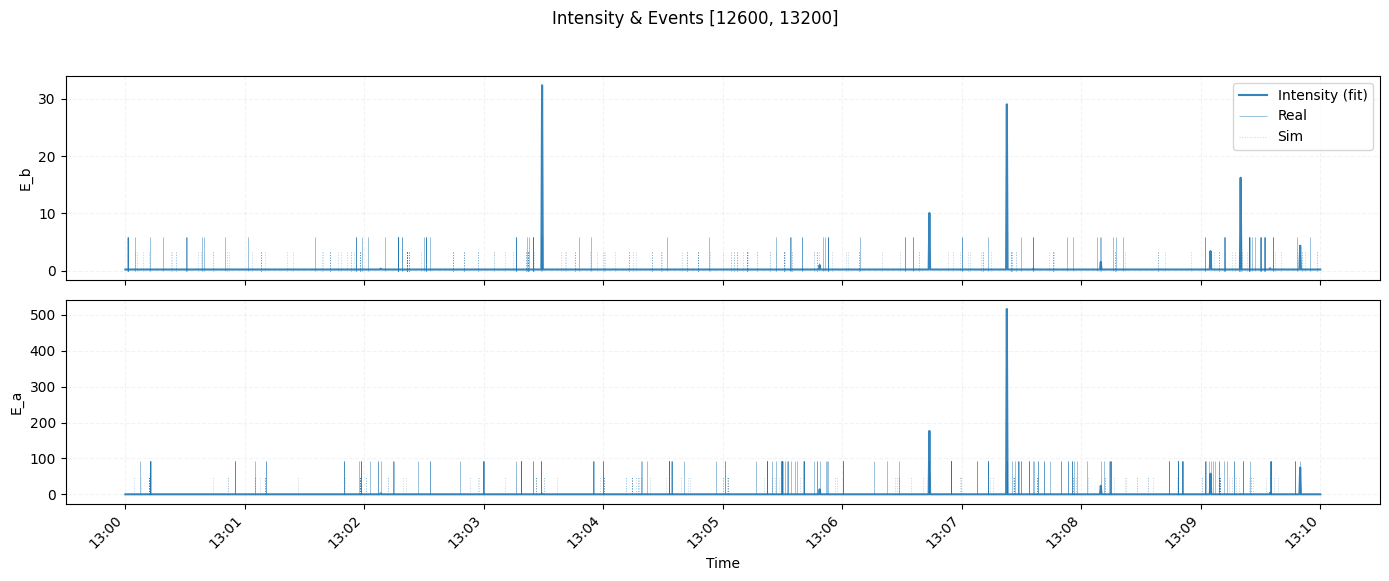

In [10]:
t0_abs = t_start
t1_abs = t_start + 10 * 60

fig, axes = plotter.plot_frame_events_and_intensity_2D(
    lob2,
    win_results,
    t0_abs=t0_abs,
    t1_abs=t1_abs,
    seed=42,
    n_grid=20_000,
    max_events=1200,
    show_clock=True,        
)
if PLOT:
    plt.show()


In [11]:
print("--- Calibrating Market (tick + sigma) and Microstructure ---\n")


quote_tick = estimate_quote_tick_from_bid_ask(
    data["bid_price"].values, data["ask_price"].values
)

mid_tick = estimate_tick_size_from_series(data["mid_price"].values)


sigma_hat = estimate_sigma_arithmetic(
    mid=data["mid_price"].values,
    t=data["time"].values,
    dt_vol=1.0
)
print(f"Estimated quote tick: {quote_tick:.4f}")
print(f"Estimated mid tick: {mid_tick:.4f}")
print(f"[CALIB] sigma_hat ≈ {sigma_hat}  (price/sqrt(s))")

def micro_cache_path(symbol: str, quote_tick: float, mid_tick: float, max_levels: int, delta_max_fit: float | None, horizon_events: int):
    dmax_tag = "None" if delta_max_fit is None else str(delta_max_fit).replace(".", "p")
    return Path(SAVE_DIR) / f"micro_params_{symbol}_qt{quote_tick:.6g}_mt{mid_tick:.6g}_L{max_levels}_dmax{dmax_tag}_h{horizon_events}.pkl"

H = 5
micro_path = micro_cache_path(symbol, quote_tick, mid_tick, max_levels=3, delta_max_fit=0.05, horizon_events=H)


def _compute_micro():

    A_fill, k_fill, delta0_fill = calibrate_fill_probability(
        lob_data=df,
        tick_size=quote_tick,
        max_levels=10,
        delta_max_fit=12 * quote_tick,
    )

    p_bar, k_imp, theta_imp = calibrate_price_impact(
        None,
        data,
        tick_size=mid_tick,
        horizon_events=5,
    )


    return dict(A_fill=A_fill, k_fill=k_fill, delta0_fill=delta0_fill,
                p_bar=p_bar, k_imp=k_imp, theta_imp=theta_imp)




micro_params = cache_load_or_compute(micro_path, _compute_micro)
A_fill = micro_params["A_fill"]
k_fill = micro_params["k_fill"]
delta0_fill = micro_params["delta0_fill"]
p_bar  = micro_params["p_bar"]
k_imp  = micro_params["k_imp"]
theta_imp = micro_params["theta_imp"]
delta0_fill = micro_params["delta0_fill"]


print(f"[CALIB] fill: A={A_fill:.4g}, k={k_fill:.4g}, delta0={delta0_fill:.6g}")
print(f"[CALIB] impact: p_bar={p_bar:.4g}, k_imp={k_imp:.4g}, theta={theta_imp:.4g}")

--- Calibrating Market (tick + sigma) and Microstructure ---

Estimated quote tick: 0.0100
Estimated mid tick: 0.0050
[CALIB] sigma_hat ≈ 0.03480629843275213  (price/sqrt(s))
[Microstructure] Fill Params (fit): A=0.3168, k_tick=0.2284 (per tick), k_price=22.8411 (per price unit), delta0=0.045000, fit_cutoff=0.120000, bins_kept=29
[Microstructure] Event-level impact: samples=34988, rho_source=rho_5L, horizon_events=5
  Sanity mean dmid1 at exec: buy(s=+1) = 0.007583846475758424  sell(s=-1) = -0.007149115601554783
  Sanity mean dmid_h:        buy(s=+1) = 0.010219106833264017  sell(s=-1) = -0.009671157110782985
[Microstructure] Directional move rate: overall=0.565, buy(up)=0.583, sell(down)=0.548
[Microstructure] Warning: parameters on bounds -> ['p_bar'] (rho may have weak predictive power).
[Microstructure] Impact Params (event-level MLE): p_bar=0.900, k=0.075880, theta=-0.752
[CALIB] fill: A=0.3168, k=22.84, delta0=0.045
[CALIB] impact: p_bar=0.9, k_imp=0.07588, theta=-0.7525


In [12]:
# --- HJB parameters ---
dt_bt = 0.002
T_hjb = 600.0
n_grid_points = int(T_hjb / dt_bt) + 1


idx_minus = COMPONENTS_2D.index("E_b")  # lambda^-
idx_plus  = COMPONENTS_2D.index("E_a")  # lambda^+

mu_plus  = fit_res.mu[idx_plus]
mu_minus = fit_res.mu[idx_minus]

beta_plus  = fit_res.beta[idx_plus]
beta_minus = fit_res.beta[idx_minus]

# A in (+,-) ordering (rows=affected intensity, cols=event type)
A_fit = fit_res.A
A_pm = np.array([
    [A_fit[idx_plus,  idx_plus],  A_fit[idx_plus,  idx_minus]],
    [A_fit[idx_minus, idx_plus],  A_fit[idx_minus, idx_minus]],
])

In [13]:
dt_hjb = 0.01
store_dt = 0.1   # 100ms invece di 1s
store_every_steps = int(round(store_dt / dt_hjb))


params = HJBSolverParams(
    T=T_hjb,
    n_time=int(T_hjb / dt_hjb),
    Q=20,
    q0=1,
    gamma=0.8,
    eta=0.02,
    eta_T=0.02,
    eta_run=1e-4,    
    sigma=sigma_hat,
    kappa_jump=mid_tick,
    quote_tick=quote_tick,
    delta_min=mid_tick,
    delta_step=mid_tick,
    delta_max=0.20,
    delta0_fill_a=delta0_fill,
    delta0_fill_b=delta0_fill,
    A_fill_a=A_fill,
    A_fill_b=A_fill,
    k_fill_a=k_fill,
    k_fill_b=k_fill,
    p_bar=p_bar,
    k_imp=k_imp,
    theta_imp=theta_imp,
    M_plus=45,
    M_minus=45,
    store_every=store_every_steps,
)

solver = HJBThetaIMEXSolver(mu_plus, mu_minus, A_pm, beta_plus, beta_minus, params)

In [14]:
def load_or_solve_hjb(
    symbol: str,
    solver,
    params: HJBSolverParams,
    cache_dir: str | Path = "cache",
    compress: int = 3,
):
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    safe_symbol = "".join(c for c in symbol if c.isalnum() or c in ("_", "-", "."))
    sig = hjb_signature(params)
    filepath = cache_dir / f"hjb_sol_{safe_symbol}_{sig}.joblib"

    if filepath.exists():
        print(f"\n[CACHE] Found saved HJB solution for '{symbol}' at '{filepath}'. Loading...")
        sol = joblib.load(filepath)
        print("[CACHE] Loaded successfully.")
    else:
        print(f"\n[CACHE] File '{filepath}' not found. Solving HJB for '{symbol}'...")
        sol = solver.solve()
        print(f"[CACHE] Saving HJB solution to '{filepath}'...")
        joblib.dump(sol, filepath, compress=compress)
        print("[CACHE] Saved.")

    return sol


sol = load_or_solve_hjb(symbol=symbol, solver=solver, params=params)
optimal_policy = HJBQuotePolicyFromSolution(sol)


[CACHE] File 'cache\hjb_sol_AAPL_d2e02aa289.joblib' not found. Solving HJB for 'AAPL'...
[CACHE] Saving HJB solution to 'cache\hjb_sol_AAPL_d2e02aa289.joblib'...
[CACHE] Saved.


In [15]:
sim_engine = HawkesCalibrator(lob2.events, T_hjb)
t_data = data["time"].values
mid_data = data["mid_price"].values

streams, (t_sim, c_sim), (t_grid, lam_grid) = sim_engine.simulate_and_intensity(
    fit_res.mu,
    fit_res.A,
    fit_res.beta,
    T=T_hjb,
    n_grid=n_grid_points,
    seed=42
)

mid_real_grid = np.interp(t_start + t_grid, t_data, mid_data)
mid0 = float(mid_real_grid[0])
mid_price = np.full_like(t_grid, mid0, dtype=float)


lam_plus_path  = lam_grid[idx_plus, :]
lam_minus_path = lam_grid[idx_minus, :]

In [16]:
backtester = ControlBacktester(
    policy=optimal_policy,
    arrival= HawkesBacktestModel(A_fill=A_fill, k_fill=k_fill, delta0_fill=delta0_fill),
    Q_max=params.Q,
    tick_size=mid_tick,
    sigma=params.sigma,
    p_bar=params.p_bar,
    k_imp=params.k_imp,
    theta=params.theta_imp,
)

In [17]:
t_grid_real, lam_plus_real, lam_minus_real = intensity_on_real_episode_2d(
    events=events,
    fit_res=fit_res,
    t_start=t_start,
    T=T_hjb,
    n_grid_points=n_grid_points
)

N_plus_counts, N_minus_counts = slice_event_counts(events, t_start, T_hjb, t_grid_real)
mid_real_grid = slice_mid_episode(data, t_start, T_hjb, t_grid_real)

res = backtester.run(
    mid=np.full_like(t_grid_real, mid_real_grid[0], dtype=float),
    mid_replay=mid_real_grid,
    t_secs=t_grid_real,
    lam_plus_path=lam_plus_real,
    lam_minus_path=lam_minus_real,
    N_plus_counts=N_plus_counts,
    N_minus_counts=N_minus_counts,
    seed=42,
)

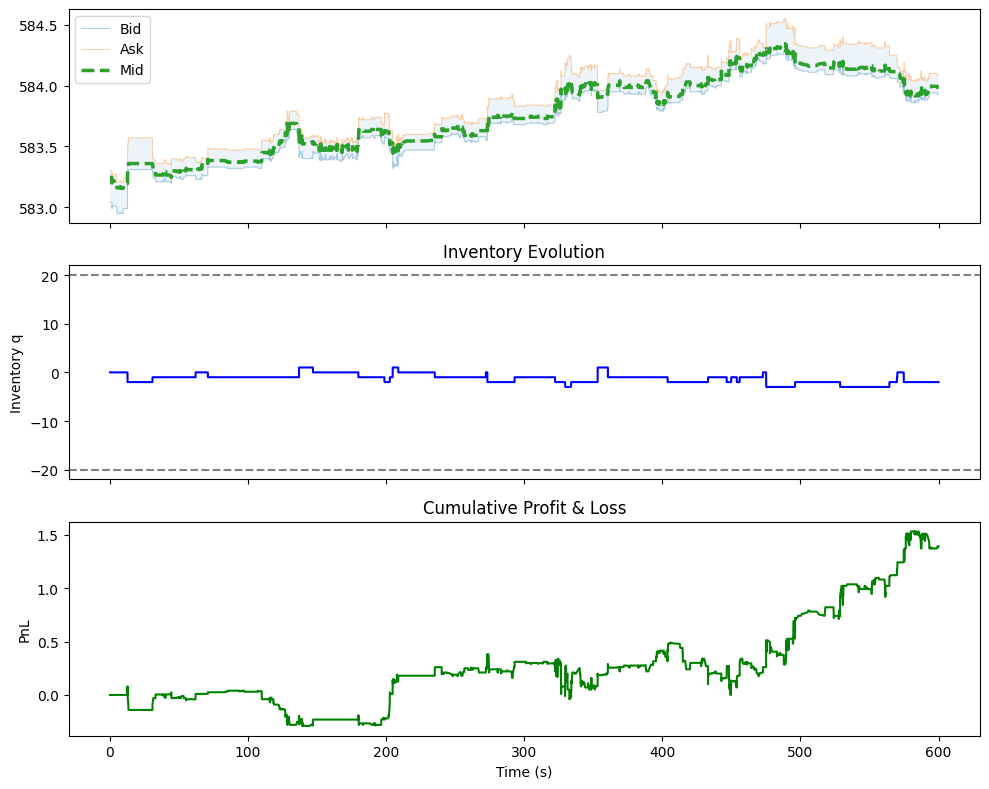

In [18]:
if PLOT:
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    ax = axes[0]

    ax.plot(res['time'], res["bid"], label="Bid", lw=0.8, alpha=0.35, zorder=1)
    ax.plot(res['time'], res["ask"], label="Ask", lw=0.8, alpha=0.35, zorder=1)

    ax.plot(res['time'], res["mid"], label="Mid", lw=2.5, ls="--", zorder=5)

    ax.fill_between(res['time'], res["bid"], res["ask"], alpha=0.08, zorder=0)

    ax.legend()


    
    axes[1].plot(res['time'], res['q'], color='blue')
    axes[1].axhline(params.Q, ls='--', color='gray')
    axes[1].axhline(-params.Q, ls='--', color='gray')
    axes[1].set_ylabel("Inventory q")
    axes[1].set_title("Inventory Evolution")
    
    axes[2].plot(res['time'], res['pnl'], color='green')
    axes[2].set_ylabel("PnL")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_title("Cumulative Profit & Loss")
    
    plt.tight_layout()
    plt.show()

In [19]:
diag = diagnostics(symbol, data, events)
diag.make_all_figures(
    fit_res=fit_res, 
    t_start=t_start,
    T=T_hjb,
    policy=backtester.policy,
    res=res, 
    A_fill=params.A_fill_a,
    k_fill=params.k_fill_a,
    p_bar=params.p_bar,
    k_imp=params.k_imp,
    theta_imp=params.theta_imp,
    quote_tick=quote_tick,
    mid_tick=mid_tick,
    hc_for_residuals=None 
)

c:\Users\andre\Desktop\Tesi\code\diagnostics.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(self.FIGDIR / f"{name}.pdf", bbox_inches="tight")
c:\Users\andre\Desktop\Tesi\code\diagnostics.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(self.FIGDIR / f"{name}.png", dpi=dpi, bbox_inches="tight")


In [20]:
report = diag.backtest_report(
    res,
    params=params,
    sol=sol,
    policy=backtester.policy,
    A_fill=A_fill, k_fill=k_fill,
    N_plus_counts=N_plus_counts,
    N_minus_counts=N_minus_counts,
    lam_plus_real=lam_plus_real,
    lam_minus_real=lam_minus_real,
    i_probe=50,
    verbose=True,
)

=== Backtest diagnostics report ===
params: gamma=0.8  eta=0.02  eta_T=0.02  eta_run=0.0001
PnL: trade=2.93564  mtm=-1.54564  total=1.39  (end_rel=1.39)
Wealth identity: ptp=1.82  max|wealth-pnl|=0
Micro: mean_spread=0.175353  mean_delta_b=0.0608002  mean_delta_a=0.114553  corr(q,skew)=-0.918398
FillModel: mean_prob ask=0.0352152  bid=0.0869459  |  exp_fills ask=7.48018  bid=9.70477  total=17.185
ExecQuality: avg_sell_cap=0.070765  avg_buy_cap=0.0354453  fills(sell)=23  fills(buy)=21  events(sell)=21  events(buy)=19
Grid hits: lam_plus_hit=0.00401332  lam_minus_hit=0.00310666
Policy sanity:
  t=0  q=10: skew=-0.075  del_b=0.205  del_a=0.055
  t=0  q=-10: skew=0.075  del_b=0.055  del_a=0.205
  i=50  q=10: skew=-0.075  del_b=0.205  del_a=0.055
  i=50  q=-10: skew=0.075  del_b=0.055  del_a=0.205


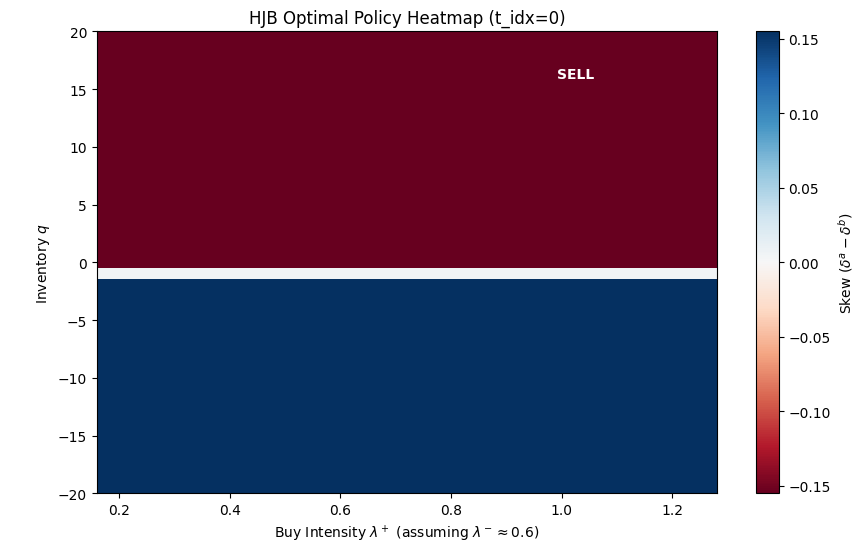

In [21]:
plot_hjb_policy_heatmap(sol, t_idx=0)

[E_a] N/T = 0.425000 | Λ/T = 0.369803 | z = 2.223
[E_b] N/T = 0.198333 | Λ/T = 0.293626 | z = -4.308


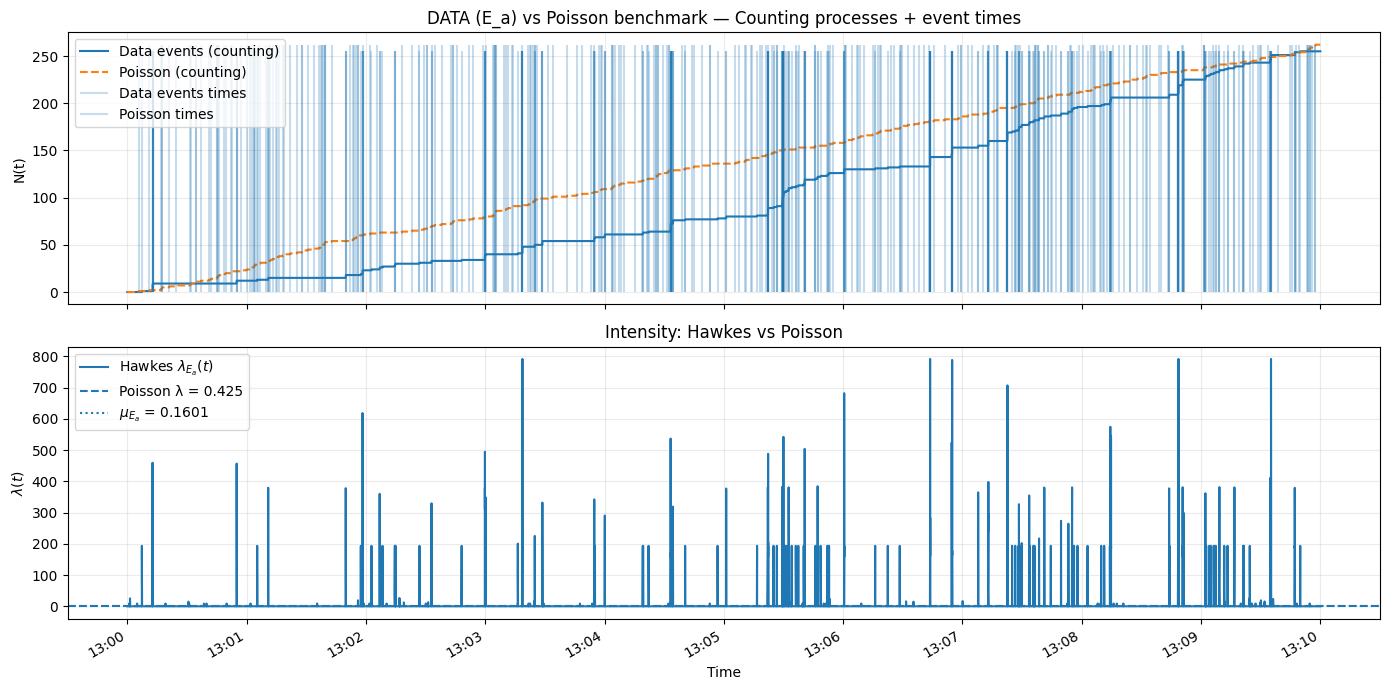

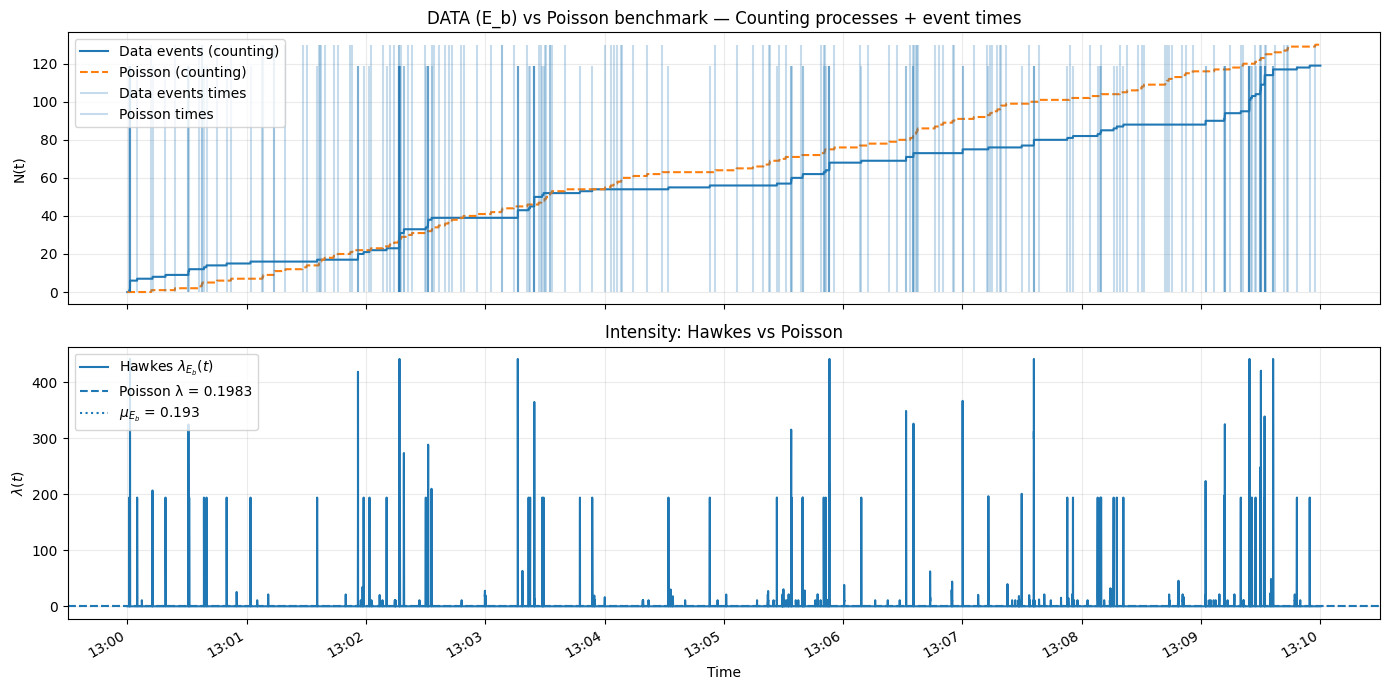

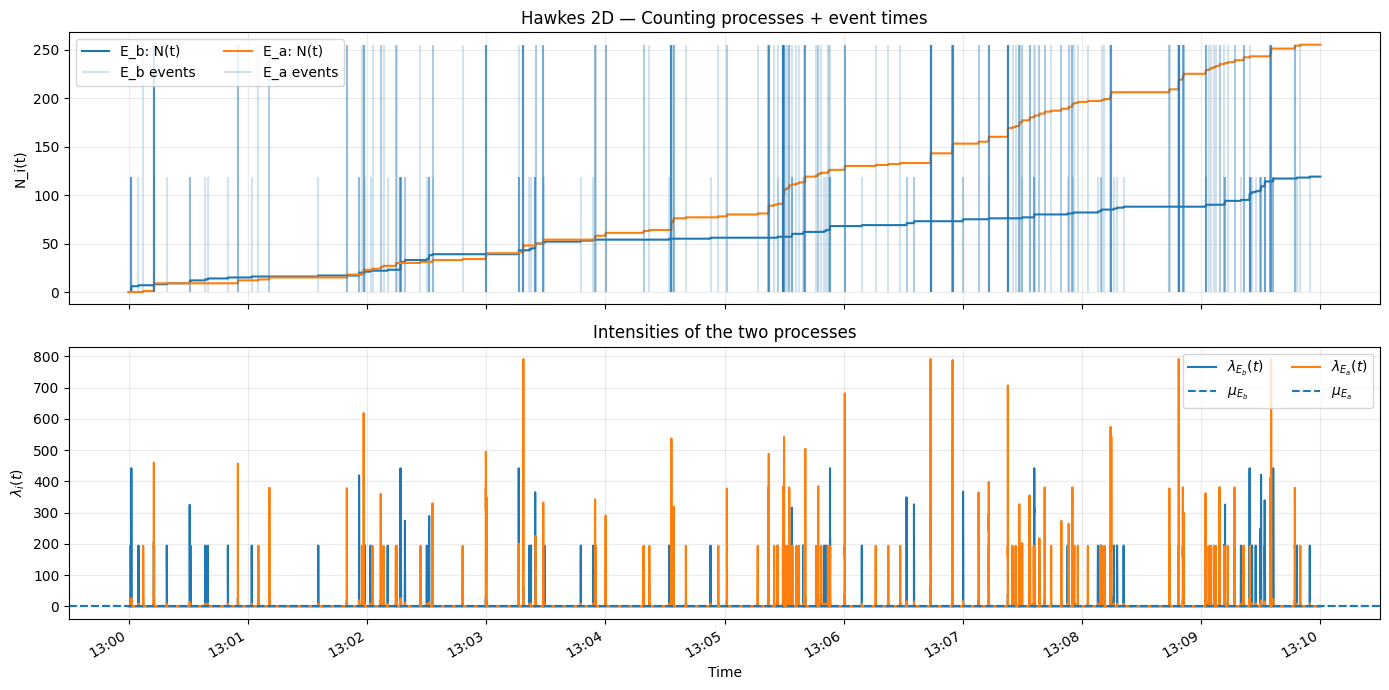

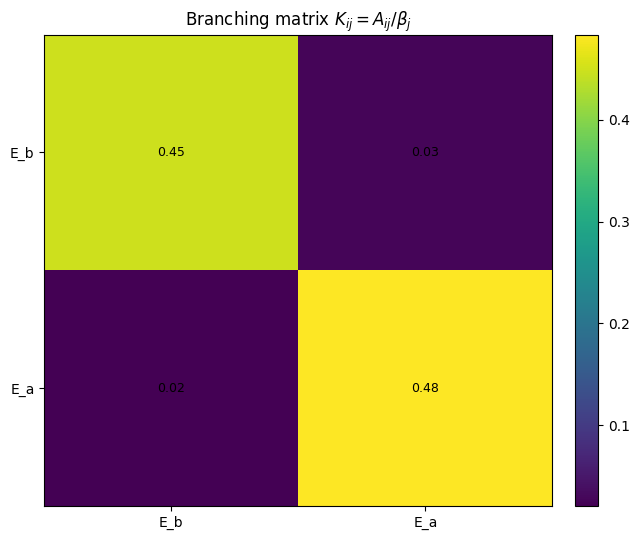

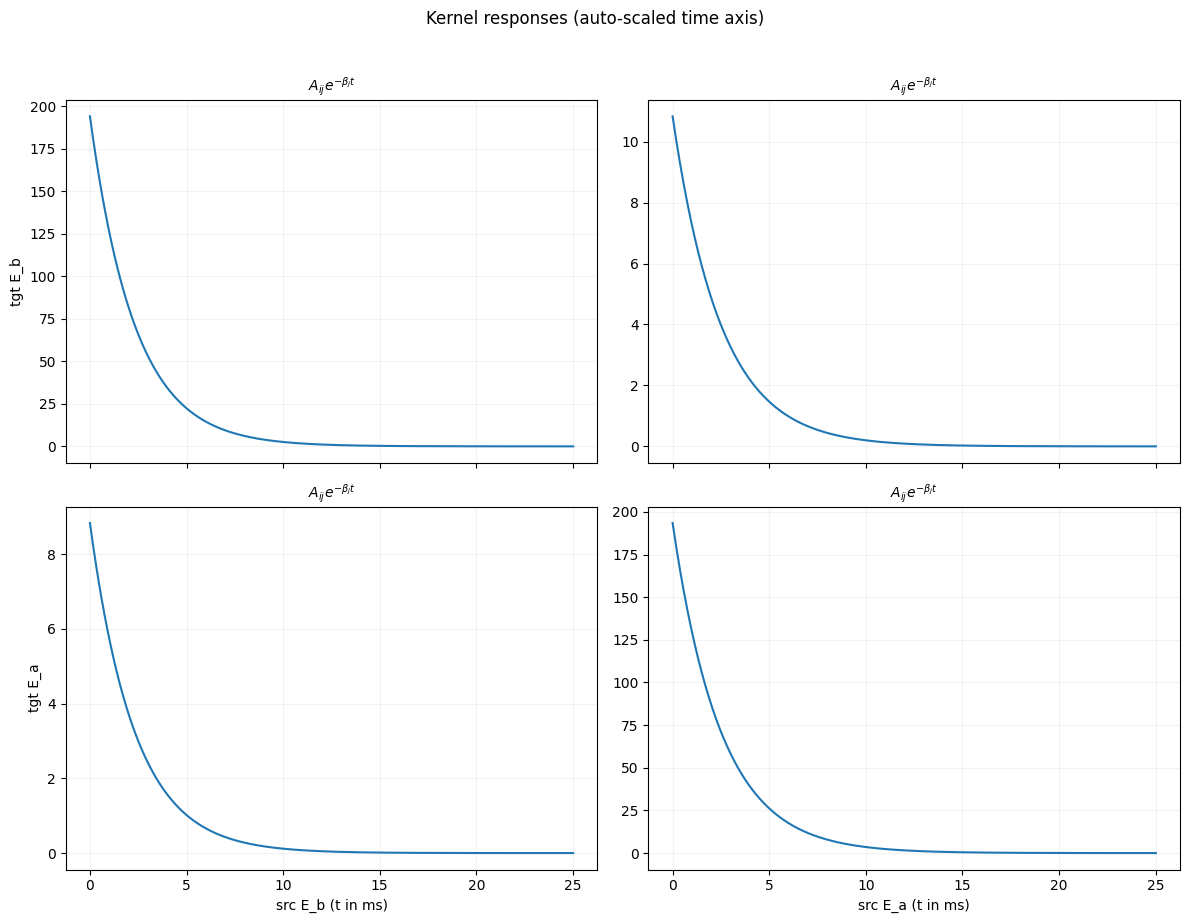

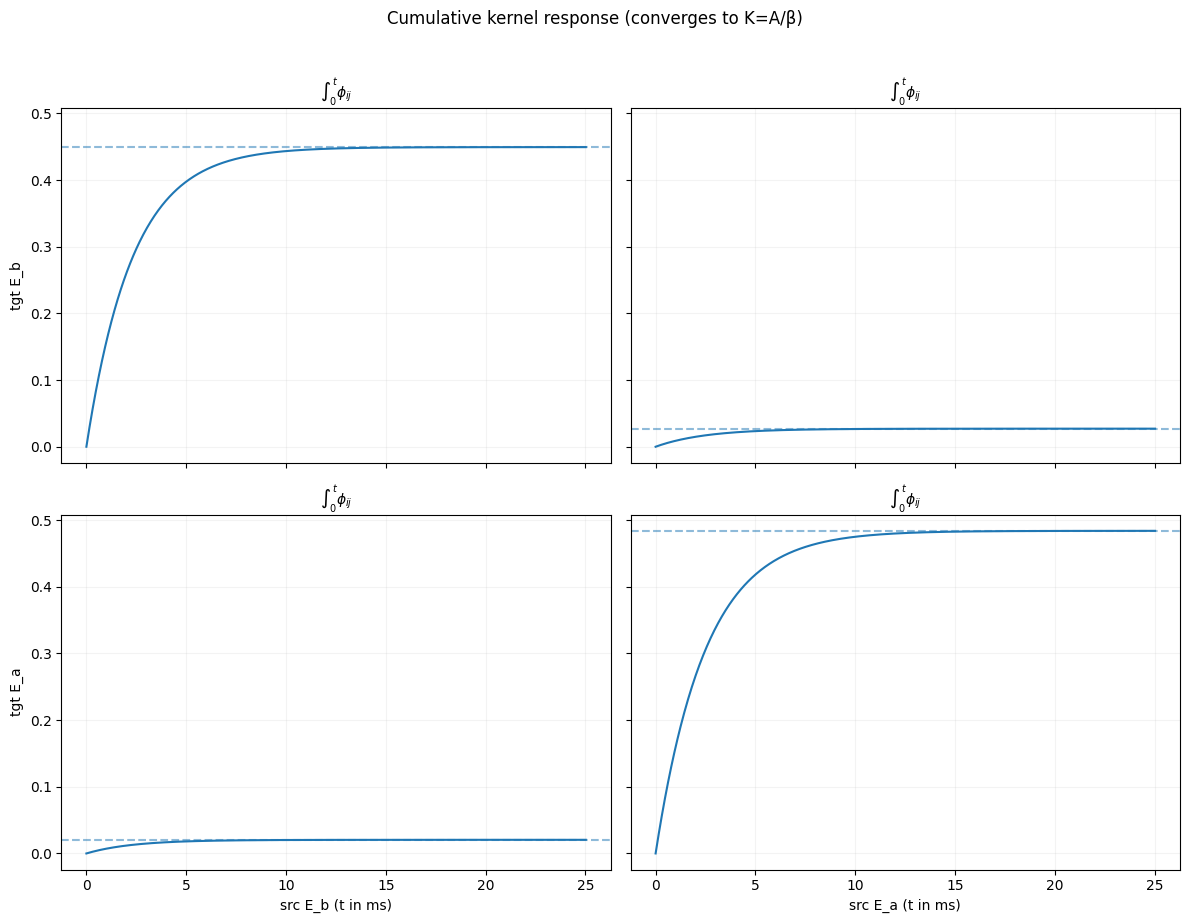

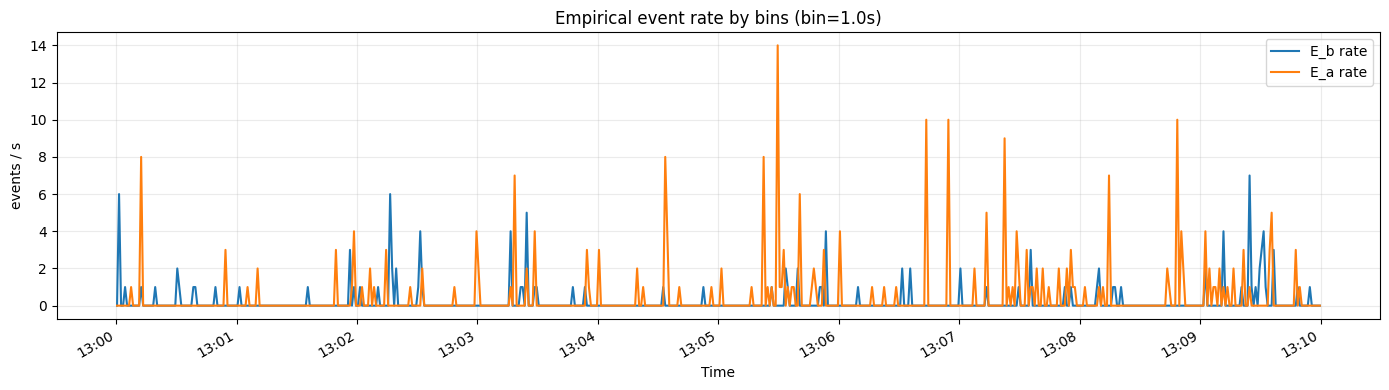

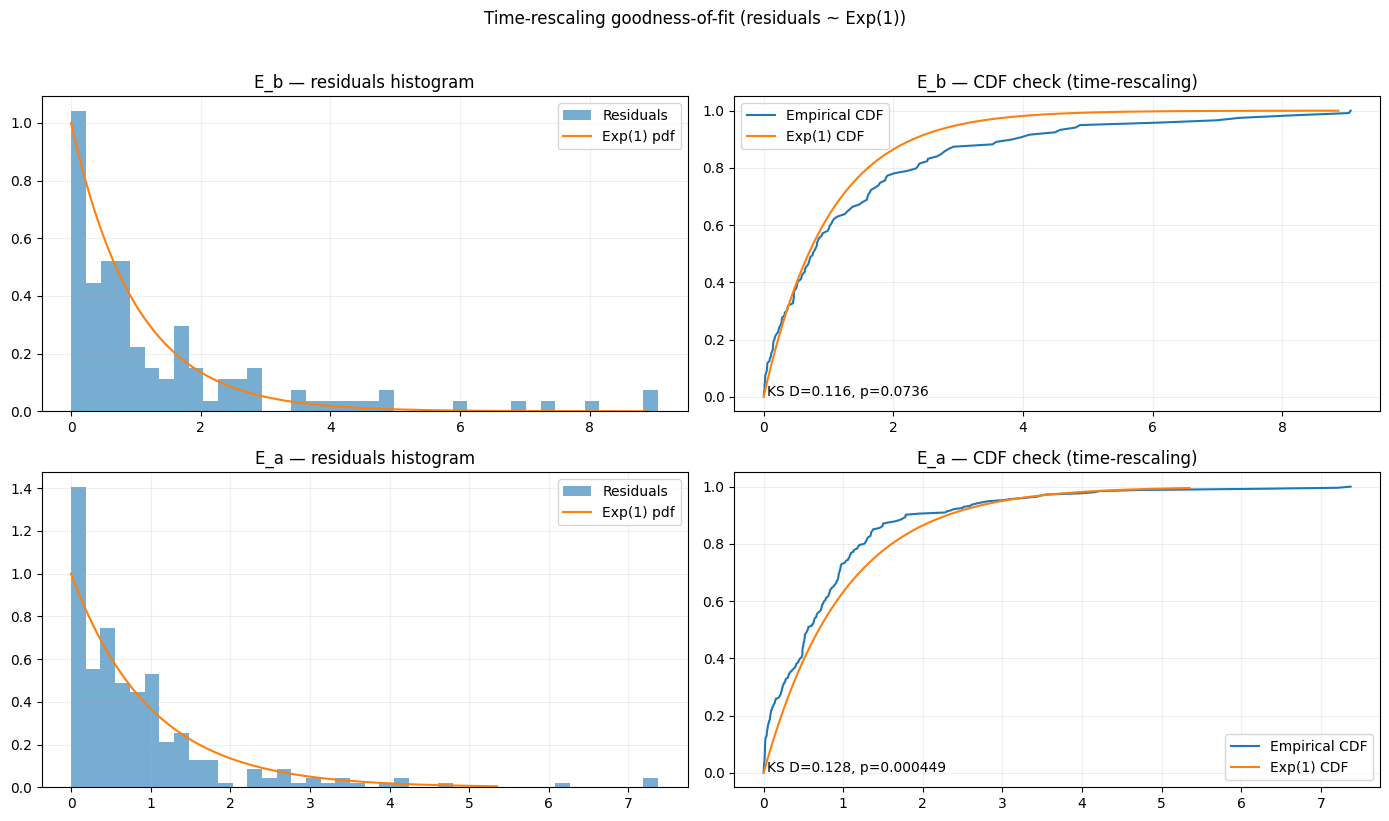

In [22]:

from  PointProcessPlotSuite import PointProcessPlotSuite

pp = PointProcessPlotSuite(events=events, fit_res=fit_res)

# scegli un episodio
T_pp = T_hjb              # es: 180s

# include some pre-history so the Hawkes intensity at t_start is not artificially reset
warmup_pp = float(max(60.0, 10.0 * np.max(1.0 / fit_res.beta)))

# genera e salva tutte le figure
figs = pp.make_suite(
    t_start=t_start,
    T=T_pp,
    warmup=warmup_pp,
    out_dir="figures/" + str(symbol),
    seed=42
)

if PLOT:
    plt.show()


<>:55: SyntaxWarning: invalid escape sequence '\g'
<>:55: SyntaxWarning: invalid escape sequence '\g'
C:\Users\andre\AppData\Local\Temp\ipykernel_26868\3181015286.py:55: SyntaxWarning: invalid escape sequence '\g'
  sns.kdeplot(res_hjb['q'], label=f"HJB ($\gamma=0.8$)", fill=True, color='blue', alpha=0.3)


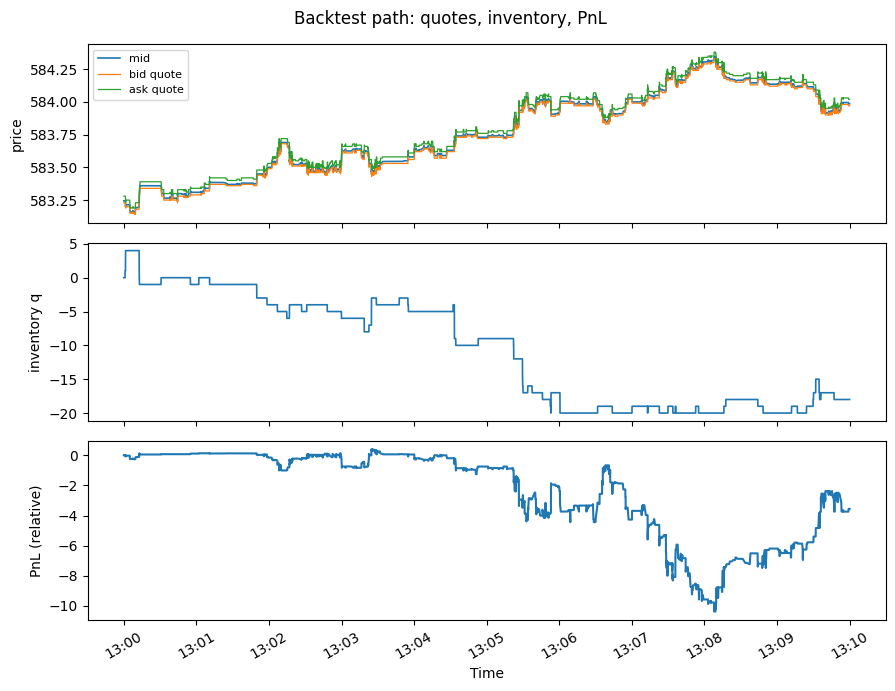

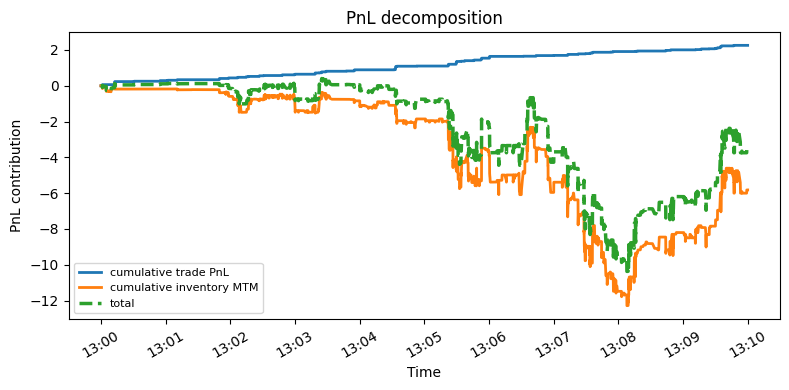

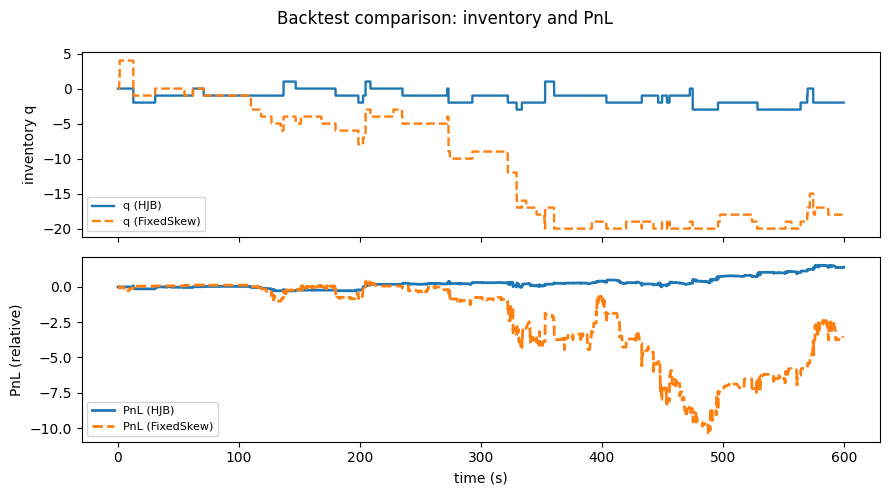

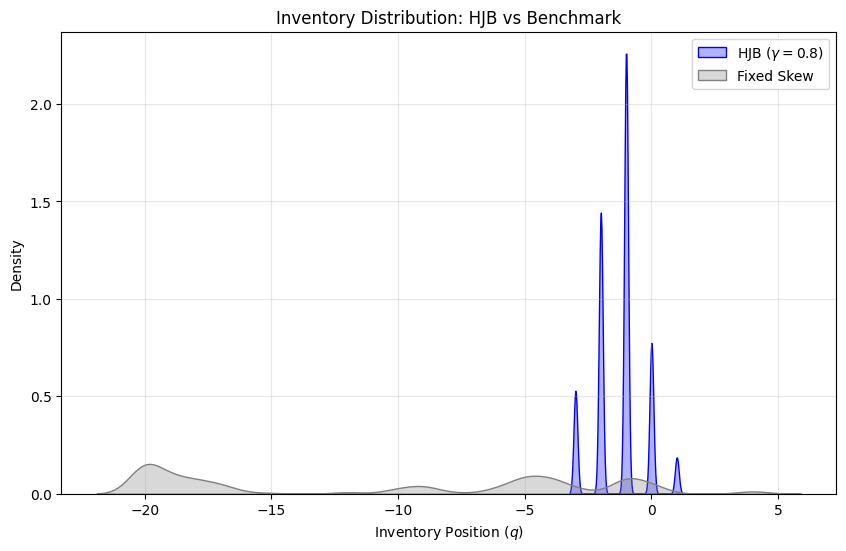

In [23]:
from control_frame import FixedSkewFromMidPolicy

fixed_policy = FixedSkewFromMidPolicy(
    delta0=2 * quote_tick,     # base half-spread
    skew=1 * quote_tick,       # fixed skew
    quote_tick=quote_tick
)

fixed_backtester = ControlBacktester(
    policy=fixed_policy,
    arrival=HawkesBacktestModel(A_fill=A_fill, k_fill=k_fill, delta0_fill=delta0_fill),
    Q_max=params.Q,
    tick_size=mid_tick,
    sigma=params.sigma,
    p_bar=params.p_bar,
    k_imp=params.k_imp,
    theta=params.theta_imp,
)

res_fixed = fixed_backtester.run(
    mid=np.full_like(t_grid_real, mid_real_grid[0], dtype=float),
    mid_replay=mid_real_grid,
    t_secs=t_grid_real,
    lam_plus_path=lam_plus_real,
    lam_minus_path=lam_minus_real,
    N_plus_counts=N_plus_counts,
    N_minus_counts=N_minus_counts,
    seed=42,   # keep same seed for a fairer comparison
)

# --- Same plot format as HJB, now for fixed-skew ---
q_grid = np.arange(-30, 31, 2)
S0 = float(np.nanmedian(data["mid_price"].values))
mu = getattr(fit_res, "mu", None)
lam_minus0 = float(mu[0]) if (mu is not None and len(mu) >= 2) else 1.0
lam_plus0  = float(mu[1]) if (mu is not None and len(mu) >= 2) else 1.0

diag.fig_policy_slices(
    fixed_policy,
    t=0.0, S=S0,
    lam_plus=lam_plus0, lam_minus=lam_minus0,
    q_grid=q_grid,
    name="D1_policy_slices_fixed_skew",
)

diag.fig_backtest_path(res_fixed, name="E1_backtest_path_fixed_skew", t0_seconds=t_start, plot=PLOT)
diag.fig_pnl_decomposition(res_fixed, name="E2_pnl_decomposition_fixed_skew", t0_seconds=t_start, plot=PLOT)
diag.fig_compare_pnl_q(res, res_fixed, labels=("HJB", "FixedSkew"), name="E1b_compare_pnl_q", t0_seconds=t_start, plot=PLOT)


def plot_inventory_distribution(res_hjb, res_fixed):
    plt.figure(figsize=(10, 6))
    
    # HJB Inventory
    sns.kdeplot(res_hjb['q'], label=f"HJB ($\gamma=0.8$)", fill=True, color='blue', alpha=0.3)
    
    # Benchmark Inventory
    sns.kdeplot(res_fixed['q'], label="Fixed Skew", fill=True, color='gray', alpha=0.3)
    
    plt.title("Inventory Distribution: HJB vs Benchmark")
    plt.xlabel("Inventory Position ($q$)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run this after your backtest loop in main.py
plot_inventory_distribution(res, res_fixed)

In [24]:
def localize_events(events_dict, t_start, T):
    out = {}
    for k, v in events_dict.items():
        v = np.asarray(v, float)
        m = (v >= t_start) & (v < t_start + T)
        out[k] = v[m] - t_start
    return out


In [25]:
events_full_raw, T_day = ob.to_hawkes_events_10d_robust(debug=False)

events_full_clean, _, _ = prepare_hawkes_events(
    events_raw=events,
    components=COMPONENTS_2D,
    collapse_tol=0.0,
    global_tie_break=True,
    eps="auto"
)

T_EP = 600.0
events_full = localize_events(events_full_clean, t_start=t_start, T=T_EP)

# your 2D events too (if needed)
events_2d = localize_events(events, t_start=t_start, T=T_EP)  # if `events` is still absolute


(<Figure size 900x480 with 1 Axes>,
 <Axes: title={'center': 'Count distribution in fixed bins: real vs simulated'}, xlabel='count per 1s bin', ylabel='probability'>,
 {'xs': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18]),
  'pmf_real': array([0.675     , 0.14      , 0.05166667, 0.05333333, 0.02      ,
         0.015     , 0.00666667, 0.01166667, 0.00333333, 0.00666667,
         0.00666667, 0.00166667, 0.00333333, 0.        , 0.        ,
         0.        , 0.        , 0.00333333, 0.00166667]),
  'pmf_sim': array([0.83666667, 0.09333333, 0.03666667, 0.01166667, 0.00333333,
         0.005     , 0.005     , 0.00166667, 0.00166667, 0.00166667,
         0.        , 0.        , 0.00166667, 0.00166667, 0.        ,
         0.        , 0.        , 0.        , 0.        ])})

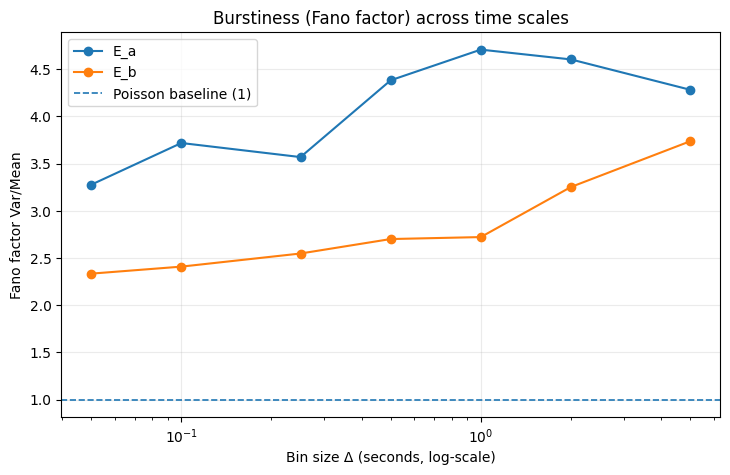

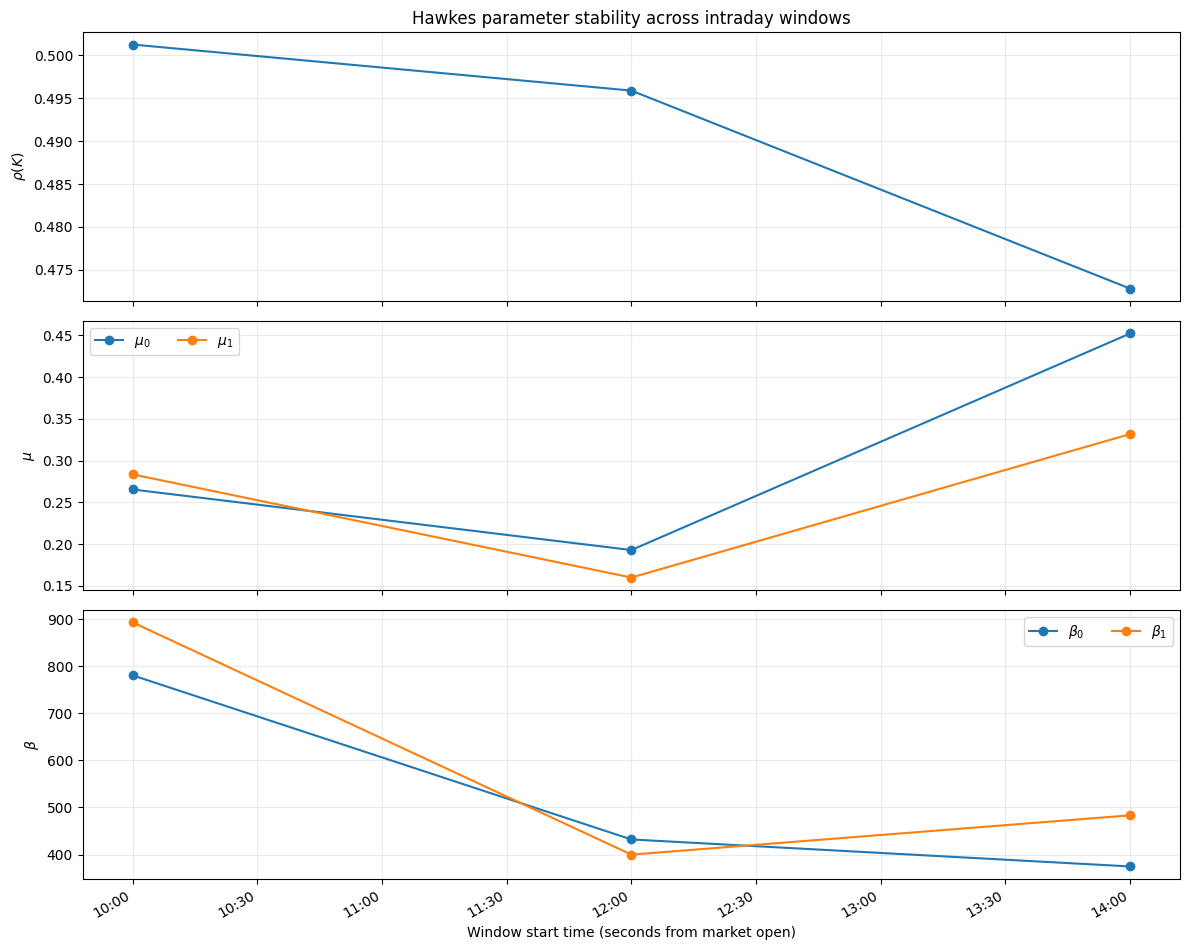

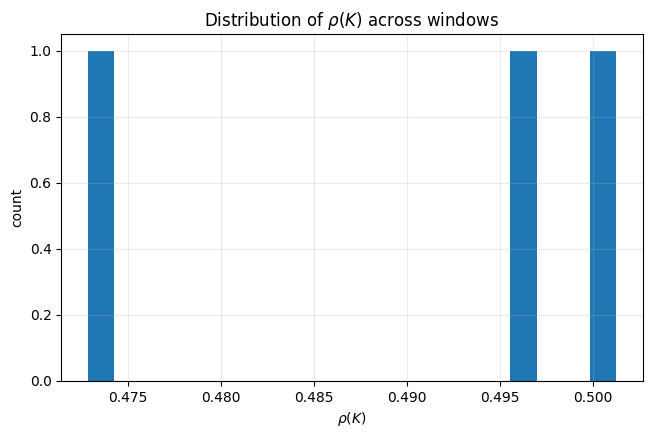

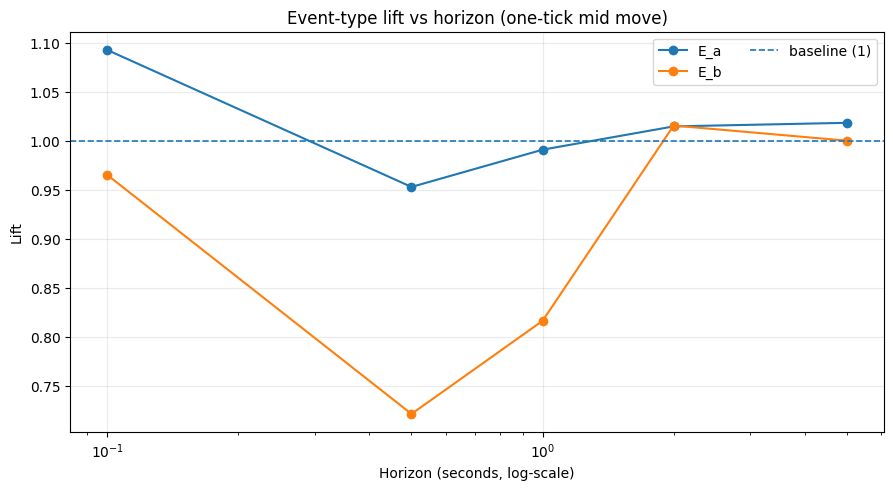

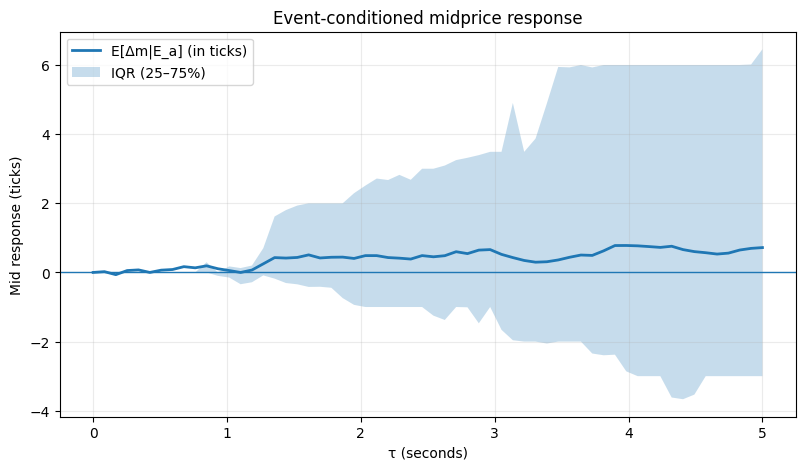

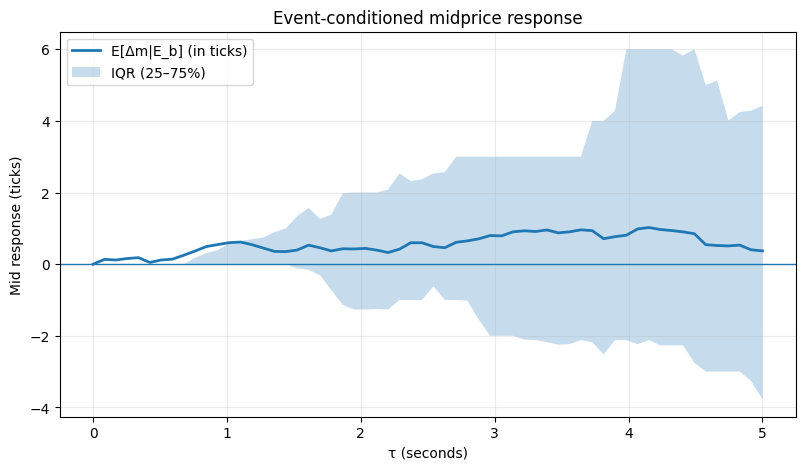

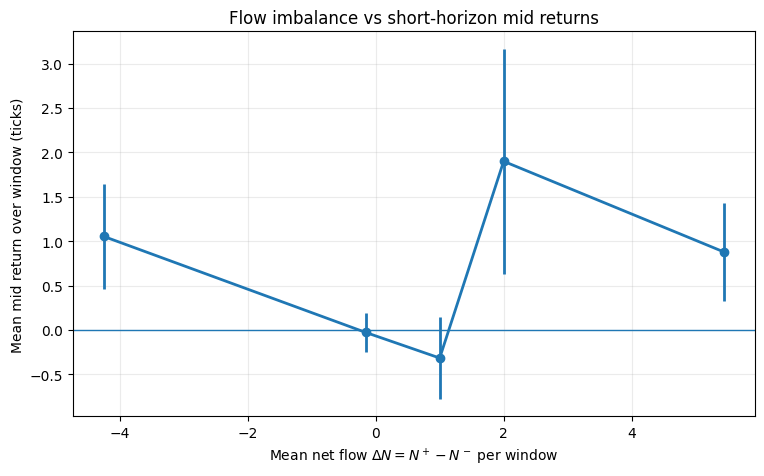

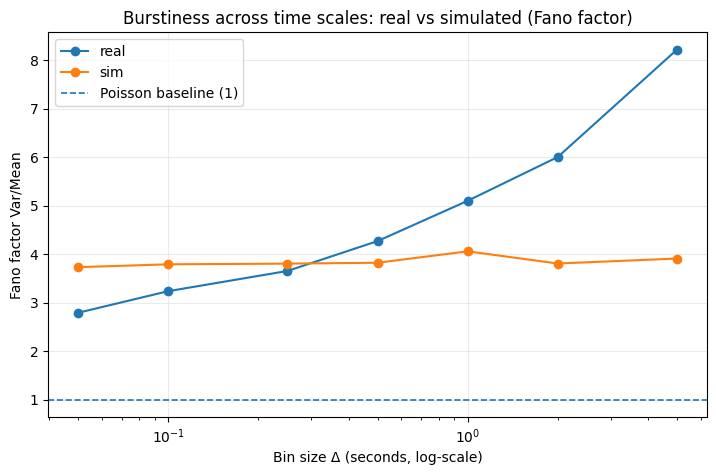

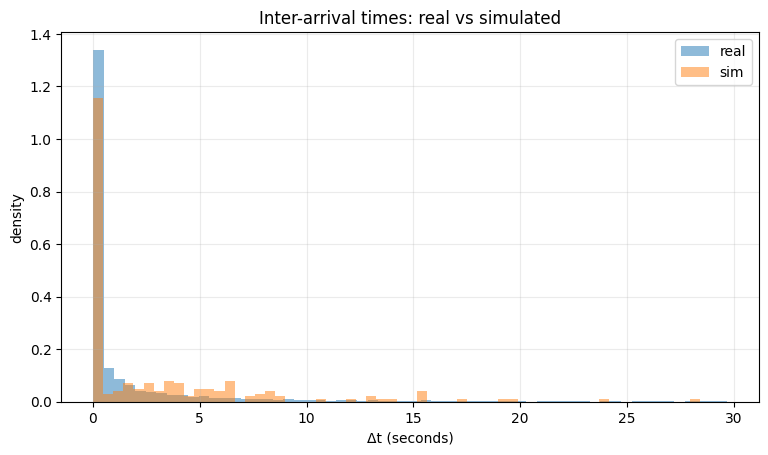

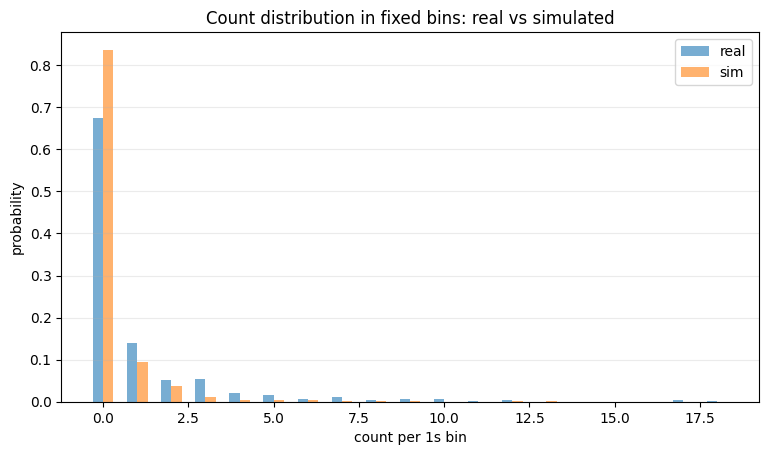

In [26]:
from thesis_figures import ThesisFigureFactory
figs = ThesisFigureFactory(out_dir="figures/" + str(symbol))

T_EP = 600.0

# Clustering justification (use localized events!)
figs.plot_fano_factor_vs_bins(events_rel=events_2d, T=T_EP, components=["E_a","E_b"],
                              save_name="B0_fano_vs_bins")

# Stability across windows (pass win_results dict directly)
figs.plot_hawkes_stability_over_windows(win_results, save_name="B0_stability_over_windows")
figs.plot_rho_histogram(win_results, save_name="B0_rho_hist")

# 2D reduction evidence (needs full events!)
mid_times  = t_grid
mid_prices = mid_real_grid
tick_size  = mid_tick

components_full = ["E_a","E_b"]  # or add HE_a, HE_b if you want
events_full, marks_full, meta_full = prepare_hawkes_events(
    events, components_full, eps="auto"
)

# Now call the lift plot with events_full (NOT events_2d)
figs.plot_event_type_midmove_lift_multi(
    mid_times=mid_times,
    mid_prices=mid_prices,
    events_rel=events_full,
    T=600,
    components=components_full,
    tick_size=tick_size,
    save_name="B0_lift_vs_horizon_full"
)

# Event impulse response
figs.plot_event_impulse_response(mid_times, mid_prices, events_full["E_a"],
                                 T=T_EP, tick_size=tick_size, label="E_a",
                                 save_name="B0_irf_Ea")

figs.plot_event_impulse_response(mid_times, mid_prices, events_full["E_b"],
                                 T=T_EP, tick_size=tick_size, label="E_b",
                                 save_name="B0_irf_Eb")

# Flow imbalance vs returns (aggressive flow -> returns)
figs.plot_flow_imbalance_vs_returns(
    mid_times, mid_prices,
    buy_mo_times=events_full["E_a"], sell_mo_times=events_full["E_b"],
    T=T_EP, tick_size=tick_size, delta=1.0,
    save_name="B0_flow_imbalance"
)

# Real vs sim (only if you simulated)
sim_events = streams
figs.plot_fano_real_vs_sim(events_full["E_a"], sim_events["E_a"], T=T_EP, save_name="B0_fano_real_sim_Ea")
figs.plot_interarrival_real_vs_sim(events_full["E_a"], sim_events["E_a"], save_name="B0_dt_real_sim_Ea")
figs.plot_count_distribution_real_vs_sim(events_full["E_a"], sim_events["E_a"], T=T_EP, save_name="B0_counts_real_sim_Ea")
